# ML Technique: T-SNE
T-sne is a dimension reduction algorithm. It's best used to visualize data with lots of features in 2D space. 

# Why not PCA?
Principle Component Analysis (PCA) is the most popular dimension reduction algorithm. While this model excels at reducing variance, it does not always product visualizations with distince clusters. Later, we compare the two methods.

# NKI Breast Cancer Data
To demonstrate through example,  we will use the NKI Breast Cancer Dataset [[1]](https://www.google.com/url?q=https://data.world/deviramanan2016/nki-breast-cancer-data&sa=D&source=docs&ust=1660151201266258&usg=AOvVaw3zOXI33wxSbCse84FI3RYY). This dataset contains gene transcription information for 273 samples. There are 3 patient attributes, 10 discrete clinical attributes, and 1554 gene attributes. Each gene attribute is a normalized ratio using common gene expression profiling techniques [[2]](https://www.nature.com/articles/415530a). 



In [1]:
import pandas as pd

# Load the data from data.world's url
df = pd.read_csv('https://query.data.world/s/qzn232rzd3msuxgnlewq4af3i4wuz7')

df.head()

,Patient,ID,age,eventdeath,survival,timerecurrence,chemo,hormonal,amputation,histtype,...,Contig36312_RC,Contig38980_RC,NM_000853,NM_000854,NM_000860,Contig29014_RC,Contig46616_RC,NM_000888,NM_000898,AF067420
0,s122,18,43,0,14.817248,14.817248,0,0,1,1,...,0.591103,-0.355018,0.373644,-0.760690,-0.164025,-0.038726,0.237856,-0.087631,-0.369153,0.153795
1,s123,19,48,0,14.261465,14.261465,0,0,0,1,...,-0.199829,-0.001635,-0.062922,-0.682204,-0.220934,-0.100088,-0.466537,-0.231547,-0.643019,-0.014098
2,s124,20,38,0,6.644764,6.644764,0,0,0,1,...,0.328736,-0.047571,0.084228,-0.695950,-0.402840,-0.099965,0.110155,-0.114298,0.258495,-0.198911
3,s125,21,50,0,7.748118,7.748118,0,1,0,1,...,0.648861,-0.039088,0.182182,-0.524640,0.037320,-0.167688,-0.016790,-0.285344,-0.251188,0.862710
4,s126,22,38,0,6.436687,6.318960,0,0,1,1,...,-0.287538,-0.286893,0.057082,-0.565021,-0.105632,-0.108148,-0.405853,-0.053601,-0.677072,0.134160


# Low Dimentional Visualization
There are many questions we could ask with such a rich dataset. "What genes correlate with each other? Can we predict survival based only on gene expression? What are the most important features when considering survival?" These questions have been addressed (to some extent) in research papers. [Wu et. al.](https://www.scirp.org/journal/paperinformation.aspx?paperid=84902) applies all the common classical machine learning techniques such as PCA, linear regression, SVM, random forest, and logistic regression. [Nicolaua et. al.](https://d1bp1ynq8xms31.cloudfront.net/wp-content/uploads/2015/02/Topology_Based_Data_Analysis_Identifies_a_Subgroup_of_Breast_Cancer_with_a_unique_mutational_profile_and_excellent_survival.pdf) uses a more advanced topology method to discover a subset of genes (c-MYB+) that, when exhibited, correlate to a 100% chance of survival. They are of a bit different caliber, but well worth a quick read if you would like to learn more about the data.

Today we will focus on the best way to visualize this data. Of course, there are many ways to visualize one feature at a time. Here are two ways to show the distribution of age and survival time, respectively:


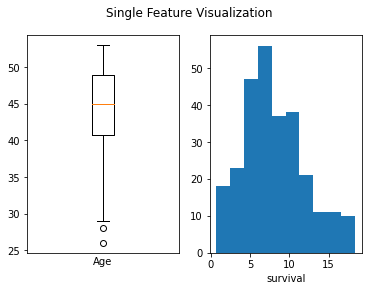

In [2]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.suptitle('Single Feature Visualization')

plt.title('Cancer Data')
plt.subplot(1, 2, 1)
plt.boxplot(df['age'])
plt.xticks([])
plt.xlabel('Age')

plt.subplot(1, 2, 2)
plt.hist(df['survival'])
plt.xlabel('survival')
plt.show()

We can also fairly easily plot 2 dimensions of data at a time:

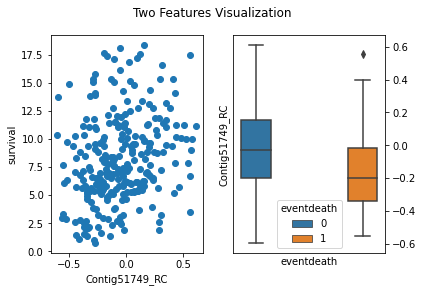

In [3]:
plt.figure(2)
plt.suptitle('Two Features Visualization')
plt.subplot(1, 2, 1)
plt.scatter(df['Contig51749_RC'], df['survival'])
plt.xlabel('Contig51749_RC')
plt.ylabel('survival')

plt.subplot(1, 2, 2)
import seaborn as sns
import numpy as np
sns.boxplot(x='eventdeath', y='Contig51749_RC', data=df, hue='eventdeath')
plt.gca().yaxis.tick_right() 
plt.xticks([])
plt.show()

Taking a look at one gene: `Contig51749_NC`, we can see how the expression of this gene corresponds to the survival time or survival rate.

In reality, it would be much more useful to take in account all the genes. To do that, we will use T-SNE.


# T-SNE explained

*Here, I attempt to summarize a [state-of-the-art 27-page paper](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) in a few short paragraphs. There are many [blogs](https://www.linkedin.com/pulse/visualization-method-sne-vs-t-sne-implementation-using-tandia), [websites](https://distill.pub/2016/misread-tsne/?_ga=2.135835192.888864733.1531353600-1779571267.1531353600), and [videos](https://youtu.be/NEaUSP4YerM) that do this better than I. I recommend checking them out too!*

## Determining Similarity of Points in Original Space
We would like similar points to be plotted next to each other, and dissimilar points to be far away. A point is similar if its features are close to each other, relative to all other points. This is exactly what Stochastic Neighbor Embedding calculates.

First, we calculate the conditional probability of j given i by finding the euclidian distance between the two points xi and xj, divided by a smoothing constant. In order to know whether this distance is actually "close" or "far", we find the distance of all the other points k and sum them.

$$ p_{j|i|}=\frac{exp(\frac{-\left\| x_i-x_j\right\|^2}{2\sigma_i^2})}{\sum_{k\neq i} exp(\frac{-\left\| x_i-x_k \right\|^2}{2\sigma_i^2})} $$

We also can imagine a case where the probability of $p_{j|i}$ is different from $p_{i|j}$. To account, we just take the average of the two probabilities.

$$ p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n} $$

## Positioning the Points in the New Space
Second, we apply the same ratio in the lower-dimentional space. Notice, the $\sigma^2$ constant is taken out. Remember that this was simply a smoothing constant (perplexity) that doesn't make sense to include in the new space.

$$ q_{ij}=\frac{exp(-\left\| y_i -y_j \right\|^2)}{\sum_{k \neq l} exp(-\left\| y_k -y_l \right\|^2)} $$

Above is the equation for SNE, which uses a Cauchy distribution. To make this "t-SNE", we will use a Student t-distribution with one degree of freedom.

$$ q_{ij}=\frac{(1+\left\| y_i -y_j \right\|^2)^{-1}}{\sum_{k \neq l}(1+\left\| y_k -y_l \right\|^2)^{-1}} $$

## Iterating over the Cost Function
Now we have the probability that the two points are close to each other in original space ( $p_{ij}$ ) and we have a prediction of how close they should be in low-D space ($q_{ij}$). If this was a perfect match $ p_{ij} $ and $ q_{ij} $ would equal each other.

So we can put this in our cost function. The author of the original paper chose to use the of Kullback-Leibler divergence. Notice how the log  in this function. This means that, given the choice between making sure similar points stay together, or similar points are far apart, the function favors clustering similar points together.

Our cost function is:

$$C = KL(P||Q)=\sum_i\sum_jp_{ij}log\frac{p_{ij}}{q_{ij}} $$

What's actually really nice about this cost function is that it's gradient decent w.r.t. $y$ is simply:

$$ \frac{\partial C}{\partial y_i} = 4\sum_j(p_{ij}-q_{ij})(y_i-y_j) $$

## Quick Summary

To review, we have a dataset that has many features. We calculate $p_{ij}$  which is a ratio that is large if $i$ and $j$ are close to each other and small if they are far apart. Then we sample an initial solution for the low-dimensional points $ q_{ij} $. We make incremental improvements to $q_{ij}$ by minimizing the cost function. The cost function will try to move similar points closer together, while pushing dissimilar points farther away. This push and pulling will eventually (hopefully) create the same clusters seen in high-D space in low-D space.

# Using sci-kit Learn's T-SNE 

One day I would like to implement T-SNE from scratch in python as [M. Farhan Tandia did here](https://www.linkedin.com/pulse/visualization-method-sne-vs-t-sne-implementation-using-tandia/). Until then, we will use sci-kit learn's T-SNE api. As a bonus, also allows us to easily compare other visualization methods.

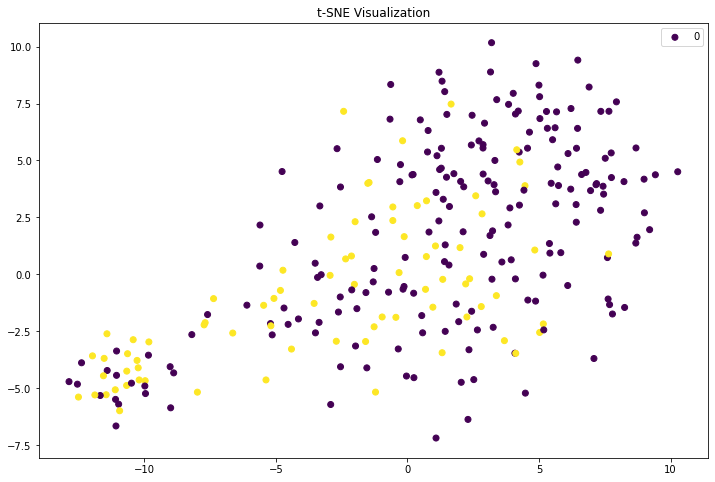

In [9]:
# normalize data using min-max scaling
from sklearn.preprocessing import MinMaxScaler
df_num = MinMaxScaler().fit_transform(df.iloc[:,16:])

# use TSNE to create a new dataframe for each point
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_results = pd.DataFrame(tsne.fit_transform(MinMaxScaler().fit_transform(df.iloc[:,16:])), columns=['tsne_x', 'tsne_y'])

# plot the results
plt.figure(figsize=(12,8))
plt.title('t-SNE Visualization')
plt.scatter(tsne_results['tsne_x'], tsne_results['tsne_y'], c=df['eventdeath'])
plt.legend(['0', '1'])
plt.show()

Patient


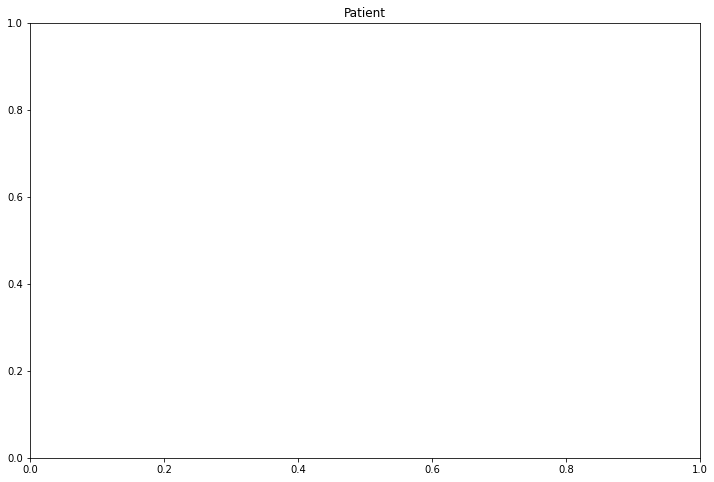

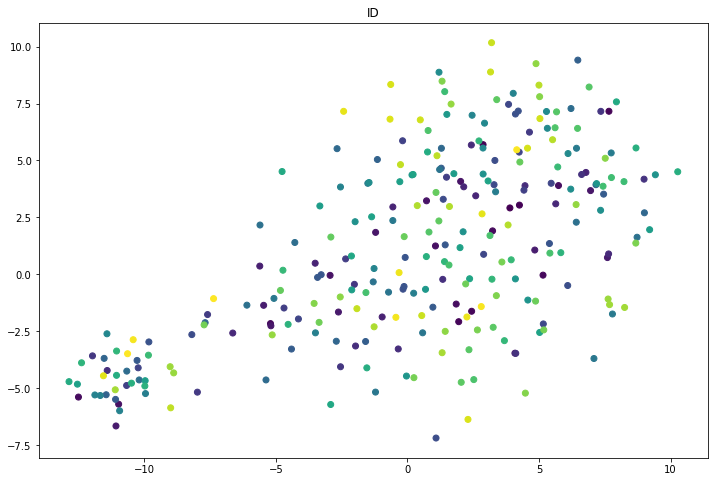

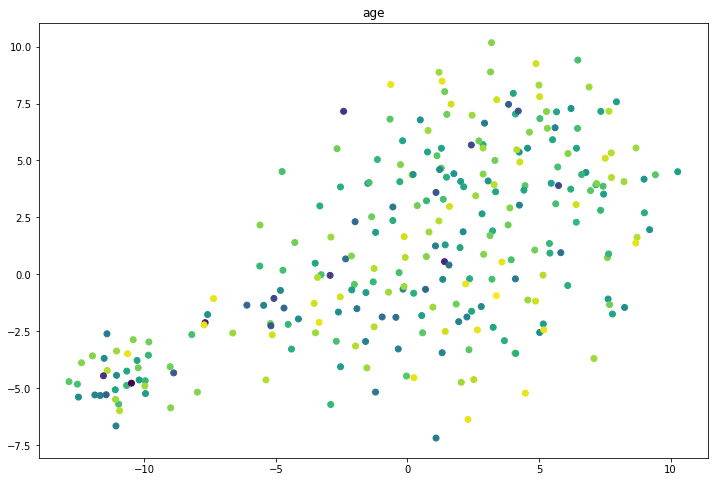

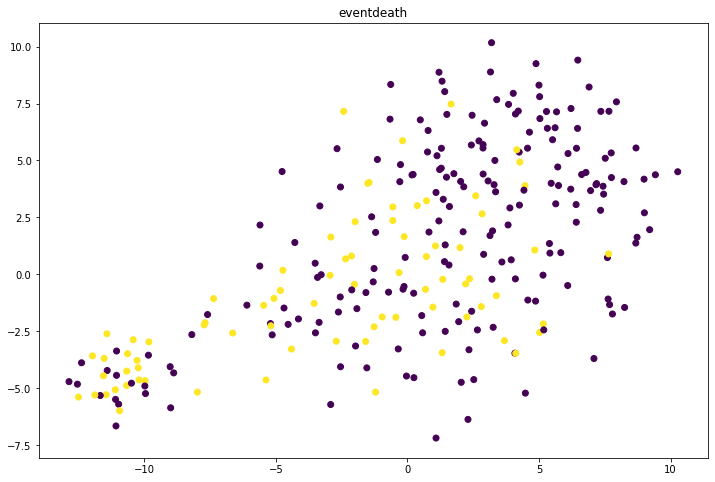

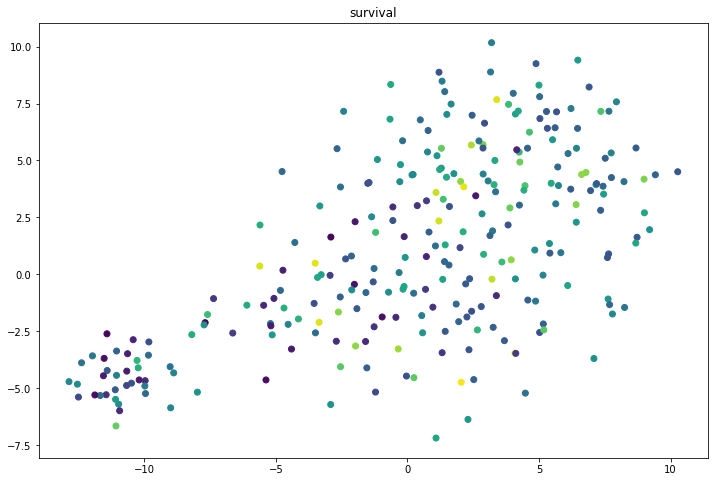

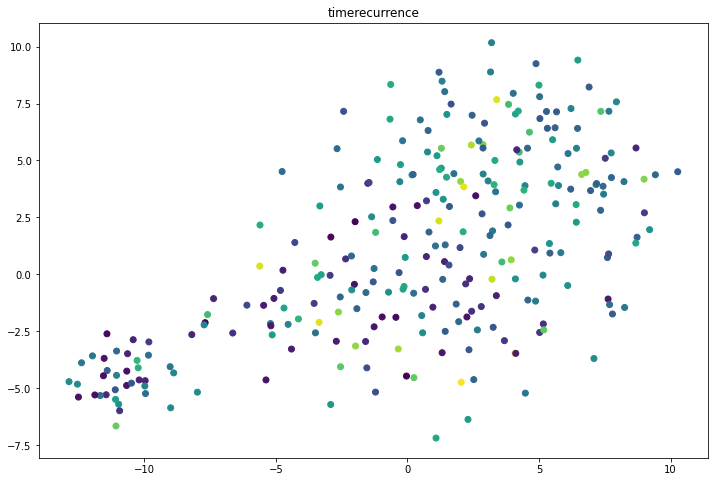

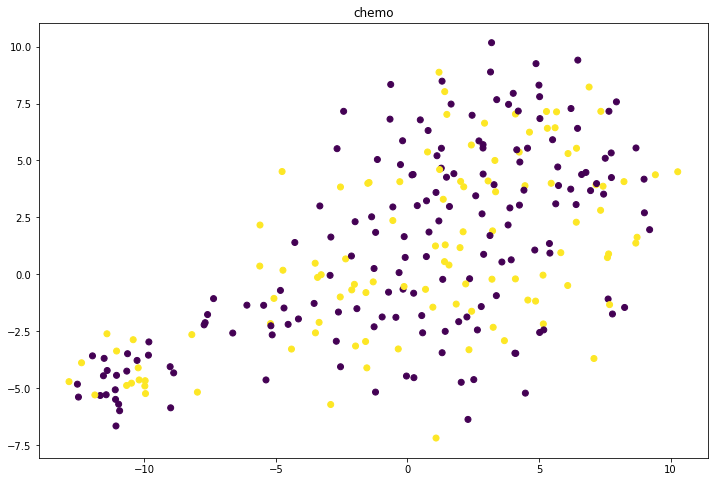

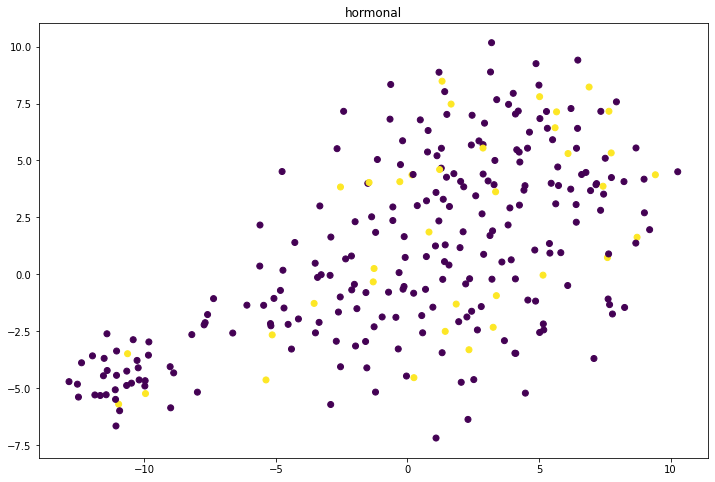

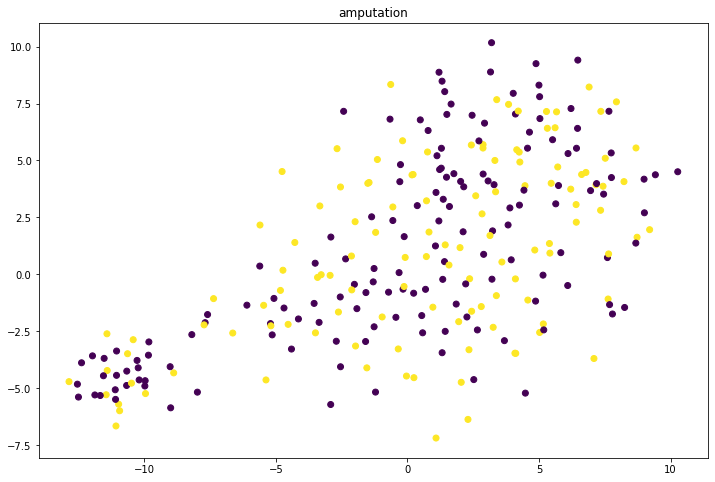

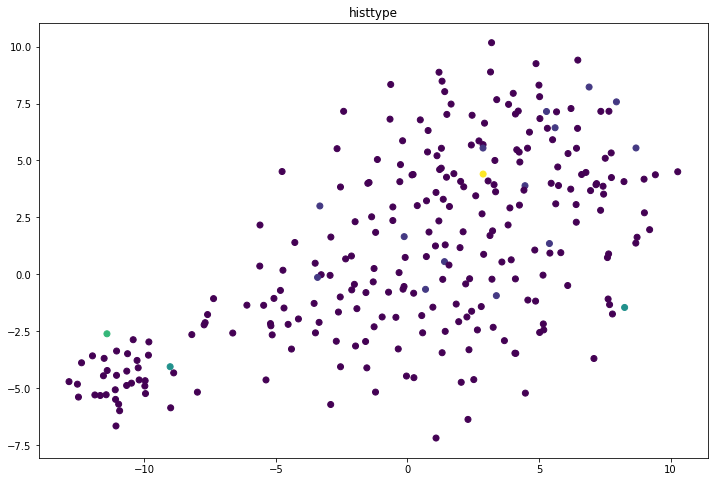

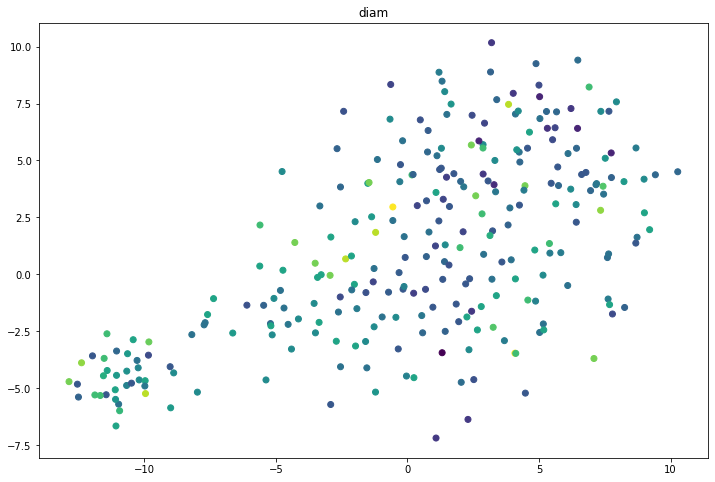

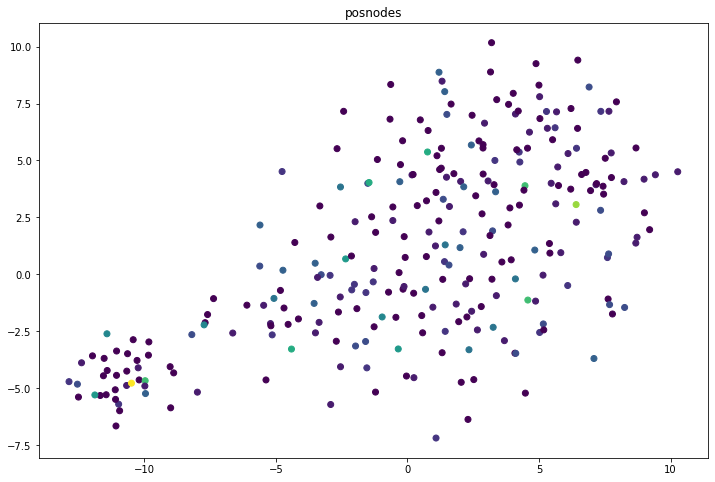

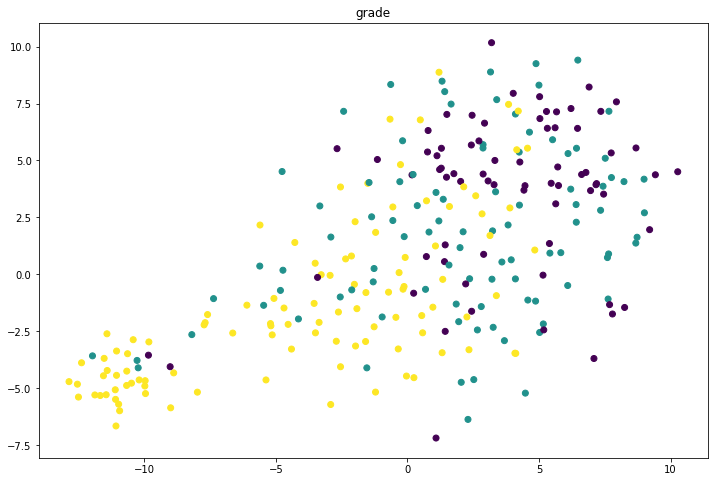

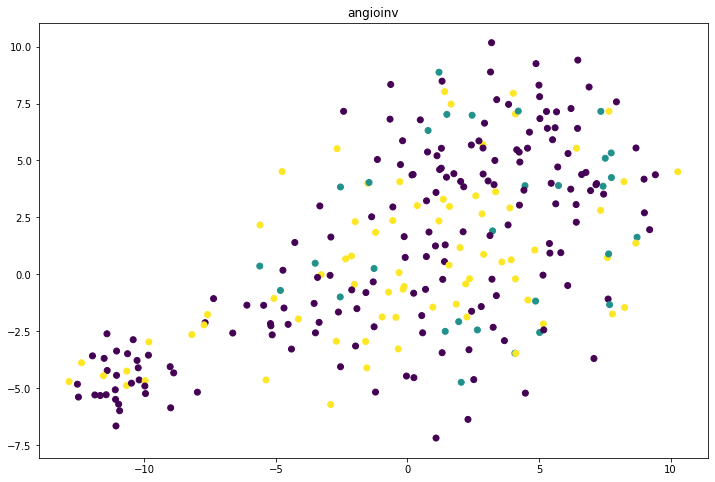

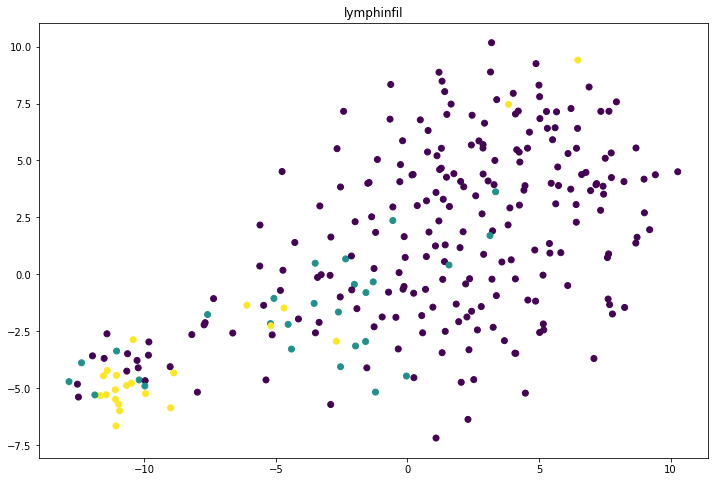

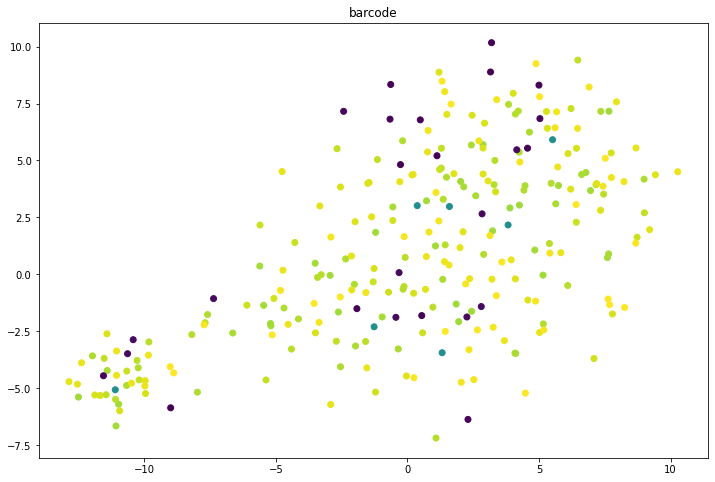

In [20]:
for col in df.columns[:16]:
    # plot the results
    try:
        plt.figure(figsize=(12,8))
        plt.title(col)
        plt.scatter(tsne_results['tsne_x'], tsne_results['tsne_y'], c=df[col])
        plt.show()
    except:
        print(col)

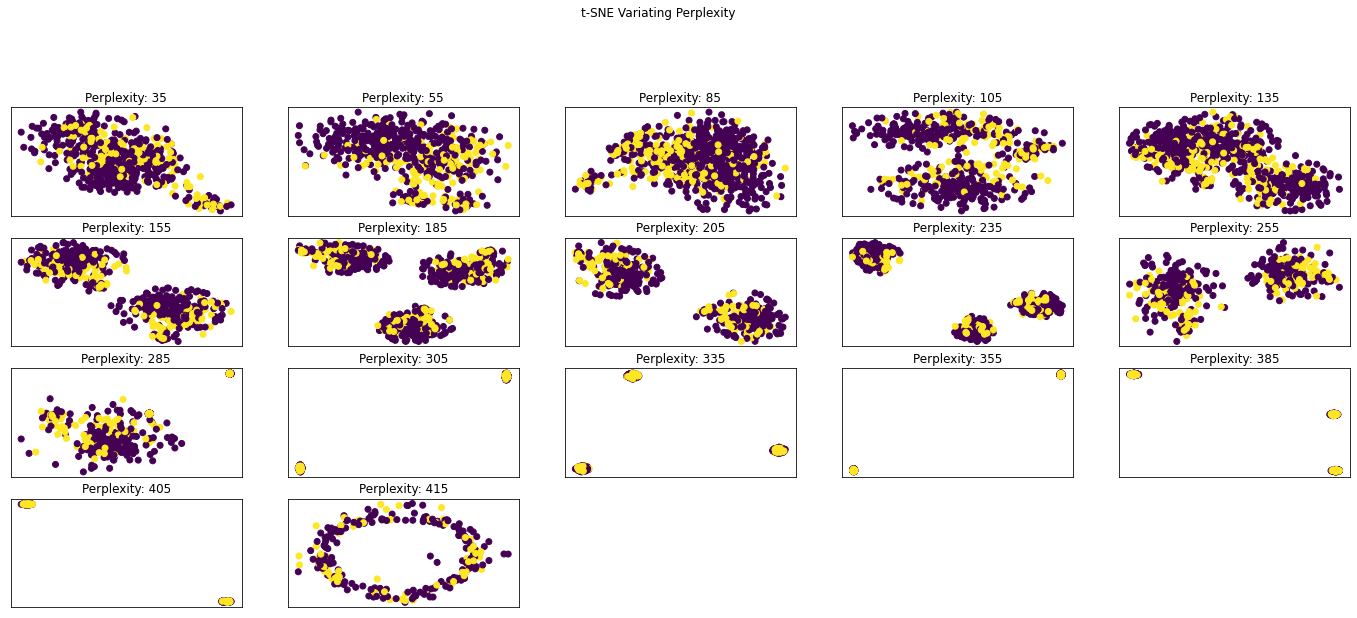

In [7]:
# Loop through  perplexity and create a scatter plot for each

plt.figure(figsize=(24,14))
plt.suptitle('t-SNE Variating Perplexity')

for perplex in range(25, 425,25):
    tsne = TSNE(n_components=2, perplexity=perplex)
    tsne_results = pd.DataFrame(tsne.fit_transform(df_num), columns=['tsne_x', 'tsne_y'])
    plt.subplot(6, 5, round(perplex/25))
    plt.title('Perplexity: ' + str(perplex))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(tsne_results['tsne_x'], tsne_results['tsne_y'], c=df['eventdeath'])

plt.show()

Notice once perplexity goes above 270, the data seems to create mini circles. This makes sense because essentially perplexity represents the number of nearest neighbors to sample. Once this goes above the number of samples (273) we cannot sample any more.

# Comparing t-SNE to PCA

Principle Component Analysis is the most popular dimensionality reduction algorithm. However, it does not always create distinct clusters between plots. Here, we compare the two.


<Figure size 432x288 with 0 Axes>

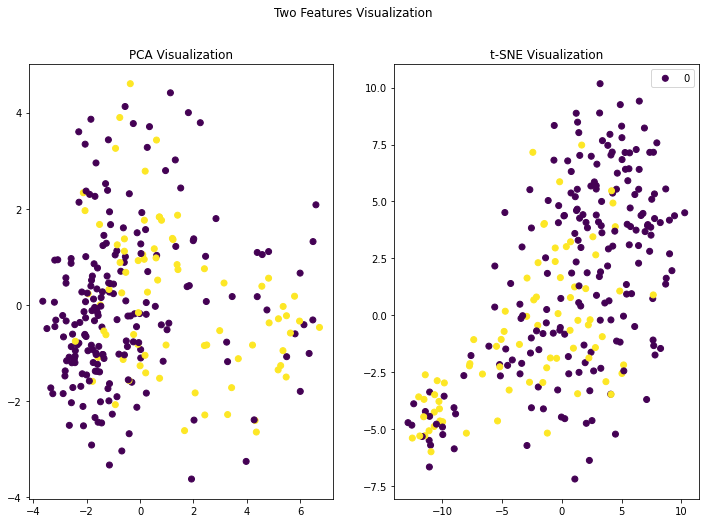

In [12]:
# Create a PCA plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_results = pd.DataFrame(pca.fit_transform(df_num), columns=['pca_x', 'pca_y'])

# plot PCA results
plt.figure(4)
plt.figure(figsize=(12,8))

plt.suptitle('Two Features Visualization')
plt.subplot(1, 2, 1)

plt.title('PCA Visualization')
plt.scatter(pca_results['pca_x'], pca_results['pca_y'], c=df['eventdeath'])

plt.subplot(1, 2, 2)
plt.title('t-SNE Visualization')
plt.scatter(tsne_results['tsne_x'], tsne_results['tsne_y'], c=df['eventdeath'])
plt.legend(['0', '1'])
plt.show()

Interestingly enough, PCA does a pretty good job of spliting `EventDeath` vertically (around x=0). However, t-SNE does a better job of creating a small cluster (in the bottom left corner). In the future, I will explore other features that may influence this cluster.